## Triangulation Using Navigator Module
This intro with demonstrate how to use the navigator module to triangulate IGS data or any RinexV3 data, do some basic data analysis of the results, see VDOPS, TDOPS, and GDOPS, and plot the results on a map.

### Triangulation Interface




The triangulation API is designed using and interface design. The main class user needs to know about is the `Triangulate` class in satlib submodule.

The `Triangulate` class always works with an interface class. These are hard coded algorathims to perform GNSS triangulation!
Currently, two interface are provided: `IterativeTriangulationInterface` which used WLS to perform triangulation and `UnscentedKalmanTriangulationInterface` which uses UKF to perform triangulation.

Let's start by importing the necessary modules and defining the interface object.


In [1]:
%load_ext autoreload
%autoreload 2
# These can be imported from top level of satlib
from navigator.core import Triangulate
from navigator.core import IterativeTriangulationInterface


# Create a triangulation object
# IterativeTriangulationInterface is a class that implements the WLS algorithm
traingulator = Triangulate(interface=IterativeTriangulationInterface())

Let's load the data into epoch objects which are the basic unit of data in the navigator module.

In [2]:
from navigator.epoch import from_rinex_files
from pathlib import Path

obsPath = Path("./data/JPLM00USA_R_20223230000_01D_30S_MO.crx.gz")
navPath = Path("./data/JPLM00USA_R_20223230000_01D_GN.rnx.gz")


epoches = list(from_rinex_files(observation_file=obsPath, navigation_file=navPath))

Processing 2022-11-19 23:59:30: 100%|██████████| 2880/2880 [00:05<00:00, 519.35it/s]


The 'from_rinex_files' method is used to load the data into epoch objects. It return a iterator[Epoch] object which can be used to iterate over the data. For small data, it is better to directly convert it to a list.

In [3]:
epoches[:10]

[Epoch(timestamp=2022-11-19 00:00:00, sv=8),
 Epoch(timestamp=2022-11-19 00:00:30, sv=8),
 Epoch(timestamp=2022-11-19 00:01:00, sv=8),
 Epoch(timestamp=2022-11-19 00:01:30, sv=8),
 Epoch(timestamp=2022-11-19 00:02:00, sv=8),
 Epoch(timestamp=2022-11-19 00:02:30, sv=8),
 Epoch(timestamp=2022-11-19 00:03:00, sv=8),
 Epoch(timestamp=2022-11-19 00:03:30, sv=8),
 Epoch(timestamp=2022-11-19 00:04:00, sv=8),
 Epoch(timestamp=2022-11-19 00:04:30, sv=9)]

As one can see, the epoch object is sorted by time and contains the range and ephermris data the satellites at that time.

### Setting the profile of the epoch before triangulation

Each epoch has a profile which can be customized to apply necessary parameter for triangulation. These parameter can be wheather to apply tropospheric correction, ionospheric correction, and the type of ionospheric correction to apply.

Let's set the dual frequency profile for the epoch object so the triangulation can be performed with dual frequency utilizing the L1 and L2 frequencies.

In [4]:
from navigator.epoch import Epoch
for epoch in epoches:
    epoch.profile = Epoch.DUAL # Set the profile to dual frequency 
    


### Triangulating the data

The triangulation is performed quite easily using the 'Triangulate' class. The 'triangulate_time_series' method is used to perform triangulation on continous epoch of data which are sorted by time.

In [5]:
df = traingulator.triangulate_time_series(epoches=epoches, override=True)

Triangulating:   0%|          | 0/2880 [00:00<?, ?it/s]

Triangulating:  56%|█████▌    | 1603/2880 [02:54<02:19,  9.14it/s]

Let's get the true coordinates of the receiver since this data is from IGS station and we know the true coordinates of the receiver.

In [ ]:
import pandas as pd
realCoord = pd.Series(Epoch.IGS_NETWORK.get_xyz(station="JPLM00USA"), index=["x", "y", "z"])

Using this we can caluclate the ENU error of the WLS triangulation.

In [ ]:
enuError = Triangulate.enu_error(
    predicted=df,
    actual=pd.DataFrame(realCoord.values.reshape(-1,1).repeat(len(df), axis=1).T, columns=realCoord.index),
)

Let's see the distribution of the ENU error.

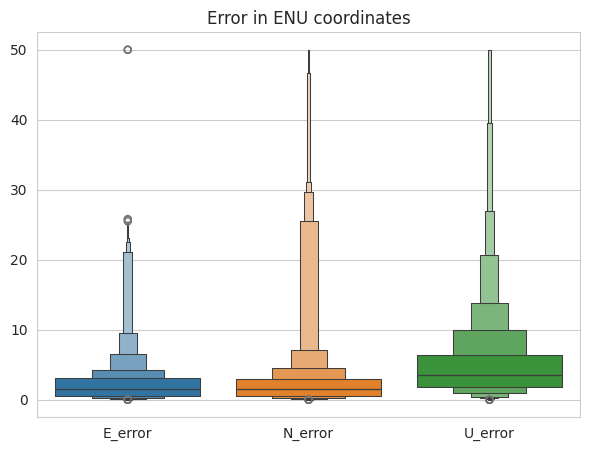

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 5))

sns.boxenplot(data=enuError.abs().clip(upper=50) , ax=ax)

ax.set_title("Error in ENU coordinates")

plt.show()

# Save the plot

# fig.savefig("ENU_error.png")

In [ ]:
import numpy as np
positionError = enuError.apply(np.linalg.norm, axis=1)

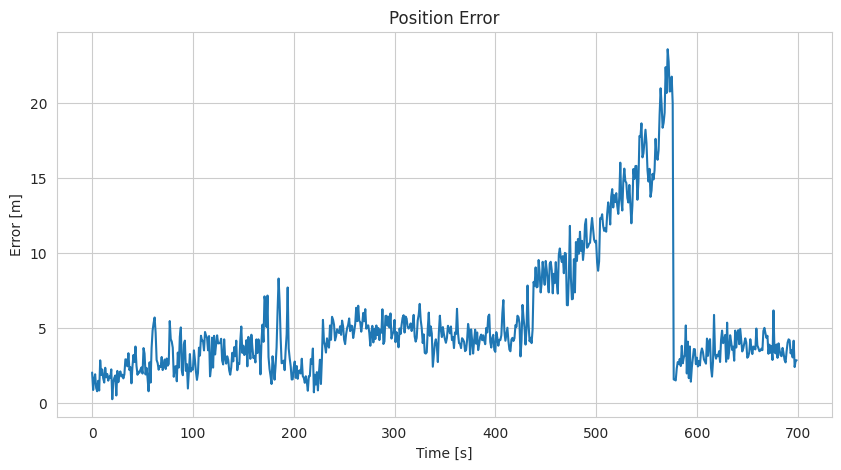

In [ ]:
pos_error , ax = plt.subplots(figsize=(10, 5))

err = positionError.clip(upper=100)

sns.set_style("whitegrid") 
sns.lineplot(x=err.index, y=err)

ax.set_title("Position Error")
ax.set_xlabel("Time [30s]")
ax.set_ylabel("Error [m]")
plt.show()


# Save the figure
pos_error.savefig("Position_error.png")